In [1]:
#First, make sure the notebook is aware of the workshop data sets
!git clone https://github.com/icomse/9th_workshop_ml_for_molecules.git
import os
os.chdir('9th_workshop_ml_for_molecules/data')

Cloning into '9th_workshop_ml_for_molecules'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 238 (delta 60), reused 41 (delta 35), pack-reused 142 (from 1)
Receiving objects: 100% (238/238), 28.43 MiB | 11.29 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (42/42), done.


In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.0 MB/s eta 0:00:00


In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [4]:
!mamba install -c conda-forge rdkit


Looking for: ['rdkit']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64   1%
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   6%
conda-forge/noarch    12%[+] 0.3s
conda-forge/linux-64  12%
conda-forge/noarch    24%[+] 0.4s
conda-forge/linux-64  15%
conda-forge/noarch    34%[+] 0.5s
conda-forge/linux-64  18%
conda-forge/noarch    37%[+] 0.6s
conda-forge/linux-64  20%
conda-forge/noarch    42%[+] 0.7s
conda-forge/linux-64  26%
conda-forge/noarch    53%[+] 0.8s
conda-forge/linux-64  31%
conda-forge/noarch    65%[+] 0.9s
conda-forge/linux-64  34%
conda-forge/noarch    77%[+] 1.0s
conda-forge/linux-64  40%
conda-forge/noarch    84%conda-forge/noarch                                
[+] 1.1s
conda-forge/linux-64  46%[+] 1.2s
conda-forge/linux-64  58%[+] 1.3s
conda-forge/linux-64  69%[+] 1.4s
conda-forge/linux-64  83%[+] 1.5s
conda-forge/linux-64  90%[+] 1.6s
conda-forge/linux-64  97%conda-forge/linux-64                              

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - py

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from rdkit import Chem

import torch

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

## Some Useful Functions:

In [2]:
# I usually keep these in a utils.py file and import them into my other files:
def smiles2geodata(smi,y, feat_dict):
    """
    Inputs:
    smi = smiles string
    y = target
    feat_dict = dictionary where keys are atoms and values are feature array (constructed using get_atom_features function)

    Outputs:
    geo_dp = pytorch geometric datapoint object
    """
    mol = Chem.MolFromSmiles(smi)
    atomic_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    atom_features = torch.tensor([feat_dict[x] for x in atomic_nums]).float()
    edges = get_edge_indices(mol)
    geo_dp = Data(x=atom_features, edge_index=edges,y=y)

    return geo_dp


def get_edge_indices(mol):
    """
    Inputs:
    mol = rdkit molecule object

    Outputs:
    torch tensor containing edge list (for inputting into smiles2geodata)
    """

    edges =[]
    for bond in mol.GetBonds():
        edges.append((bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()))

    edges = [[x[0] for x in edges],[x[1] for x in edges]]

    return torch.tensor(edges,dtype=torch.long)


def get_atom_features(smi_list):
    """
    One-hot encodes atom types and constructs a dictionary to convert atom types into feature vectors

    Inputs:
    smi_list = list of all smiles in the dataset

    Outputs:
    feat_dict = dictionary where keys are atoms and values are feature array
    """

    atom_types = []
    for smi in smi_list:
        mol = Chem.MolFromSmiles(smi)
        atom_types.extend([atom.GetAtomicNum() for atom in mol.GetAtoms()])

    atom_set = list(set(atom_types))

    enc = OneHotEncoder()
    enc.fit(np.array(atom_set).reshape(-1,1))
    feat_dict = {x:enc.transform([[x]]).toarray()[0] for x in atom_set}

    return feat_dict

### Building a deep learning model in Pytorch requires building multiple objects and routines:

1. <u>Dataset</u>- object that contains your training/validation data

2. <u>Model</u>- object that contains your model architecture and weights

3. <u>Train Routine</u>- function that passes training data through model and updates weights

4. <u>Validation Routine</u>- function that passes validation through model and reports performance

## 1. Dataset

In [99]:
data_path = '9th_workshop_ml_for_molecules/data/lipo_smiles.csv'
df = pd.read_csv(data_path)
df.head()

,smiles,lipo
0,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54
1,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18
2,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69
3,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37
4,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10


In [33]:
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

In [34]:
class GeoDataset(InMemoryDataset):
    def __init__(self, root='./',raw_name=data_path,processed_name='lipo_processed.pt',transform=None, pre_transform=None):

        self.filename = os.path.join(root,raw_name)
        # self.processed_filename = os.path.join(root,processed_name)

        # read a csv from that path:
        self.df = pd.read_csv(self.filename)

        # assign dataset attribute "input_vectors" to be the 2048 bit vector representing each molecule:
        self.x = self.df[self.df.columns[0]].values

        # assign dataset attribute "output_targets" to be the scalar representing binding strength (last column):
        self.y = self.df[self.df.columns[-1]].values


        super(GeoDataset, self).__init__(root, transform, pre_transform)

        self.data, self.slices = torch.load(self.processed_paths[0],weights_only=False)


    def processed_file_names(self):
        return ['data.pt']

    def process(self):

        feat_dict = get_atom_features(self.x)

        data_list = [smiles2geodata(x,y,feat_dict) for x,y in zip(self.x,self.y)]

        data, slices = self.collate(data_list)

        torch.save((data, slices), self.processed_paths[0])


## 2. Model

In [97]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import aggr

In [36]:
class GCN_Geo(torch.nn.Module):

    def __init__(self, hidden_dim_gcn=256, hidden_dim_fcn=256):
        super(GCN_Geo, self).__init__()

        self.conv1 = GCNConv(12, hidden_dim_gcn)
        self.conv2 = GCNConv(hidden_dim_gcn, hidden_dim_gcn)

        self.readout = aggr.SumAggregation()

        self.linear1 = nn.Linear(hidden_dim_gcn, hidden_dim_fcn)
        self.linear2 = nn.Linear(hidden_dim_fcn, 1)

    def forward(self, data):

        # Message passing layers:
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Aggregate to get molecule level features:
        x= self.readout(x,data.batch)

        # FCNN to predict molecular property:
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)

        return x.view(-1,)

## Pulling it all together

In [98]:
from torch_geometric.loader import DataLoader

In [91]:
device = torch.device('cpu')
model = GCN_Geo().to(device)

dataset = GeoDataset()
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
loss_fn = torch.nn.MSELoss()

In [104]:
model.train()
for epoch in range(30):
    print('Epoch: {}'.format(epoch))
    for batch in dataloader:

        optimizer.zero_grad()

        out = model(batch)

        loss = loss_fn(out.double(), batch.y.double())

        loss.backward()

        optimizer.step()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


In [105]:
def predict(model, dataloader):

    # Set our model to evaluation mode:
    model.eval()

    X_all = []
    y_all = []
    pred_all = []

    # Remove gradients:
    with torch.no_grad():

        # Looping over the dataloader allows us to pull out or input/output data:
        for batch in dataloader:

            # Make a prediction:
            pred = model(batch)

            X_all.append(batch.x)
            y_all.append(batch.y)
            pred_all.append(pred)

    X_all = torch.concat(X_all)
    y_all = torch.concat(y_all)
    pred_all = torch.concat(pred_all)

    return X_all, y_all, pred_all

In [106]:
x,y,pred = predict(model,dataloader)

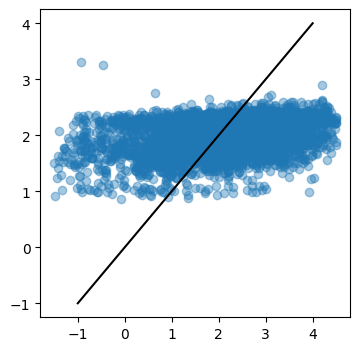

In [107]:
plt.figure(figsize=(4,4))
plt.scatter(y,pred,alpha=0.4)
plt.plot([-1,4],[-1,4],color='k')
plt.show()

In [103]:
r2_score(y,pred)

0.07468203939604212

***HACKING:*** We didn't include training/validation splits! Can you go back and including training and validation splits, using the FCNN code from the previous section as a reference?

Epoch 00, Train Loss: 3.2252, Val Loss: 1.2989
Epoch 01, Train Loss: 1.4302, Val Loss: 1.3664
Epoch 02, Train Loss: 1.4252, Val Loss: 1.3386
Epoch 03, Train Loss: 1.4004, Val Loss: 1.2347
Epoch 04, Train Loss: 1.3741, Val Loss: 1.2238
Epoch 05, Train Loss: 1.3617, Val Loss: 1.2237
Epoch 06, Train Loss: 1.3647, Val Loss: 1.2254
Epoch 07, Train Loss: 1.3652, Val Loss: 1.3347
Epoch 08, Train Loss: 1.3533, Val Loss: 1.2402
Epoch 09, Train Loss: 1.3771, Val Loss: 1.2928
Epoch 10, Train Loss: 1.3769, Val Loss: 1.3600
Epoch 11, Train Loss: 1.3409, Val Loss: 1.2395
Epoch 12, Train Loss: 1.3338, Val Loss: 1.2321
Epoch 13, Train Loss: 1.3408, Val Loss: 1.2455
Epoch 14, Train Loss: 1.3252, Val Loss: 1.2262
Epoch 15, Train Loss: 1.3343, Val Loss: 1.1902
Epoch 16, Train Loss: 1.3377, Val Loss: 1.1875
Epoch 17, Train Loss: 1.3044, Val Loss: 1.2104
Epoch 18, Train Loss: 1.3056, Val Loss: 1.1855
Epoch 19, Train Loss: 1.3295, Val Loss: 1.1936
Epoch 20, Train Loss: 1.2967, Val Loss: 1.1957
Epoch 21, Tra

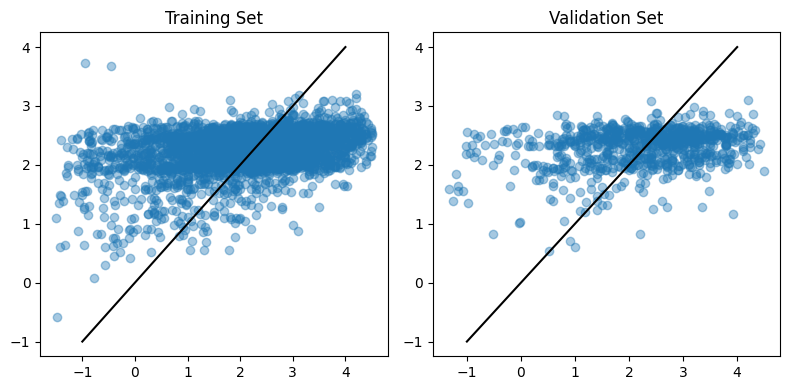

In [110]:
# Model definition remains the same
class GCN_Geo(torch.nn.Module):
    def __init__(self, hidden_dim_gcn=256, hidden_dim_fcn=256):
        super(GCN_Geo, self).__init__()
        self.conv1 = GCNConv(12, hidden_dim_gcn)
        self.conv2 = GCNConv(hidden_dim_gcn, hidden_dim_gcn)
        self.readout = aggr.SumAggregation()
        self.linear1 = nn.Linear(hidden_dim_gcn, hidden_dim_fcn)
        self.linear2 = nn.Linear(hidden_dim_fcn, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.readout(x, data.batch)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x.view(-1,)

# Modified training setup with splits
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

device = torch.device('cpu')
model = GCN_Geo().to(device)

# Create dataset and split
dataset = GeoDataset()
train_dataset, val_dataset = random_split(
    dataset,
    [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

# Modified training loop with validation
model.train()
for epoch in range(30):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out.double(), batch.y.double())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            loss = loss_fn(out.double(), batch.y.double())
            val_loss += loss.item() * batch.num_graphs

    # Calculate metrics
    avg_train_loss = train_loss / len(train_dataset)
    avg_val_loss = val_loss / len(val_dataset)

    print(f'Epoch {epoch:02d}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}')

# Modified prediction function to handle different splits
def predict(model, dataloader):
    model.eval()
    pred_all, y_all = [], []
    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch)
            pred_all.append(pred)
            y_all.append(batch.y)
    return torch.cat(y_all), torch.cat(pred_all)

# Generate predictions for both splits
y_train, pred_train = predict(model, train_loader)
y_val, pred_val = predict(model, val_loader)

# Calculate and print R² scores
from sklearn.metrics import r2_score
print(f'Train R²: {r2_score(y_train, pred_train):.4f}')
print(f'Val R²: {r2_score(y_val, pred_val):.4f}')

# Plot both results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.scatter(y_train, pred_train, alpha=0.4)
ax1.plot([-1,4], [-1,4], color='k')
ax1.set_title('Training Set')

ax2.scatter(y_val, pred_val, alpha=0.4)
ax2.plot([-1,4], [-1,4], color='k')
ax2.set_title('Validation Set')

plt.tight_layout()
plt.show()